$\newcommand{\mb}[1]{\mathbf{ #1 }}$
$\newcommand{\bs}[1]{\boldsymbol{ #1 }}$
$\newcommand{\bb}[1]{\mathbb{ #1 }}$

$\newcommand{\R}{\bb{R}}$

$\newcommand{\ip}[2]{\left\langle #1, #2 \right\rangle}$
$\newcommand{\norm}[1]{\left\Vert #1 \right\Vert}$

$\newcommand{\der}[2]{\frac{\mathrm{d} #1 }{\mathrm{d} #2 }}$
$\newcommand{\derp}[2]{\frac{\partial #1 }{\partial #2 }}$

# Finite Dimensional Koopman Bilinear System

Consider a nonlinear dynamical system that allows an exact finite dimensional Koopman canonical transform such that the control-affine dynamics can be transformed to a bilinear system. Consider the dynamical system 

\begin{equation}
\mb{\dot{x}}=\mb{f}_0(\mb x) + \mb f_1 ( \mb x) u_1 + \mb f_2(\mb x) u_2, 
\end{equation}

where we for this example choose $\mb f_0, \mb f_1$ as follows:

\begin{equation}
\mb f_0(\mb x) = \begin{bmatrix} x_3 \\ x_4 \\ \lambda x_3 \\ \mu x_4 + (2 \lambda - \mu) c x_3^2 \end{bmatrix}, \qquad
\mb f_1(\mb x) = \begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \end{bmatrix}, \qquad
\mb f_2(\mb x) = \begin{bmatrix} 0 \\ 0 \\ 0 \\ x_1+1 \end{bmatrix}, 
\end{equation}   

and $\lambda, \mu, c \in \mathbb{R}$ are scalar parameters of the system. Setting $ \mb x = [q_1 \, q_2 \, \dot{q_1} \, \dot{q_2}]^T$, 
these equations of motion can be expressed as robotic dynamics of the form $\mb{D}(\mb{q})\ddot{\mb{q}} + \mb{C}(\mb{q}, \dot{\mb{q}})\dot{\mb{q}} + \mb{G}(\mb{q}) = \mb{B}\mb{u}$, where $\mb D$ is the inertia matrix, $\mb C$ is the matrix of Coriolis terms, $\mb G$ is the matrix of gravitational terms, and $\mb B$ is the static actuation matrix. Rewriting $\mb f_0, \mb f_1, \mb f_2$ in terms of $\mb D, \mb C, \mb G,$ and $\mb B$ yield


\begin{equation}
\mb D(\mb q) = \begin{bmatrix} 1 & 0\\ 0 &  \frac{1}{q_1+1} \end{bmatrix}, 
\qquad \mb C(\mb q, \mb{\dot{q}}) = -\begin{bmatrix} \lambda & 0 \\ \frac{1}{q_1 + 1}(2 \lambda - \mu) c \dot{q}_1 & \frac{1}{q_1 +1} \mu \end{bmatrix}, \qquad 
\mb G(\mb q) = \begin{bmatrix} 0 \\ 0 \end{bmatrix} 
\qquad \mb B = \begin{bmatrix}1 & 0 \\ 0 & 1 \end{bmatrix},
\end{equation}

In [7]:
import numpy as np

from core.dynamics import RoboticDynamics

class FiniteDimKoopSys(RoboticDynamics):
    def __init__(self, lambd, mu, c):
        RoboticDynamics.__init__(self, 2, 2)
        self.params = lambd, mu, c
    
    def D(self, q):
        return np.array([[1, 0],[0, (q[0]+1)**(-1)]])
    
    def C(self, q, q_dot):
        labmd, mu, c = self.params
        return -np.array([[lambd, 0], [(q[0]+1)**(-1)*(2*lambd - mu)*c*q_dot[0], (q[0]+1)**(-1)*mu]])
    
    def G(self, q):
        return np.array([0, 0])
    
    def B(self, q):
        return np.array([[1, 0], [0, 1]])
    
lambd, mu, c = .3, .2, -.5
n, m = 4, 2
finite_dim_koop_sys = FiniteDimKoopSys(lambd, mu, c)

### Collect data from the system under PD control

We first collect data from the system under PD control designed by LQR on the linearization of the dynamics around the 
origin. This is done by picking 20 intial conditions $\mb x_0 = [q_0, \dot{q}_0]^T$ uniformly at random in the space 
$\mb x_0 \in [-2, 2]^4$. The linearized dynamics around the origin are:

In [8]:
from core.controllers import PDController
from scipy.linalg import solve_continuous_are

A_lin = np.array([[0, 0, 1, 0],
                  [0, 0, 0, 1],
                  [0, 0, lambd, 0],
                  [0, 0, 0, mu]])
B_lin = np.array([[0, 0],
                  [0, 0],
                  [1, 0],
                  [0, 1]])
lin_dynamics = (A_lin, B_lin)

q, r = 5, 1
Q_fb = q * np.identity(4)
R_fb = r*np.identity(2)
P = solve_continuous_are(A_lin, B_lin, Q_fb, R_fb)
K = np.linalg.inv(R_fb)@B_lin.T@P
K_p, K_d = K[:,:int(n/2)], K[:,int(n/2):]
pd_controller = PDController(finite_dim_koop_sys, K_p, K_d)

Finally, we collect the data and store the state and action pairs that will be used to learn dynamics models later on:

In [9]:
import random as rn
from koopman_core.controllers.perturbed_controller import PerturbedController

n_traj = 50                                                 # Number of trajectories to collect data from
dt = 1.0e-2                                                 # Time step length
N = int(5./dt)                                              # Number of time steps
t_eval = dt * np.arange(N + 1)                              # Simulation time points
traj_bounds = [2., 2., 2., 2.]                                        # State constraints, [q, q_dot]
pert_noise_var = 2.                                        # Variance of controller perturbation noise

pert_lqr_controller = PerturbedController(finite_dim_koop_sys, pd_controller, pert_noise_var)

xs, us, us_nom, ts = [], [], [], []
for ii in range(n_traj):
    x_0 = np.asarray([rn.uniform(-i,i)  for i in traj_bounds])
    xs_tmp, us_tmp = finite_dim_koop_sys.simulate(x_0, pert_lqr_controller, t_eval)
    xs.append(xs_tmp)
    us.append(us_tmp)
    ts.append(t_eval)

xs, us, ts = np.array(xs), np.array(us), np.array(ts)

### Learn lifted linear state space model with EDMD

To learn a lifted state space model with EDMD, we use a monomial basis. I.e. we use all monomials up a specified degree
such that the lifting function $\bs{\phi}(\mb x)$ is

\begin{equation}
\mb z = \bs{\phi}(\mb x) = [1 \quad x_1 \quad \dots  \quad x_n \quad x_1^2 \quad x_1 x_2 \quad x_n^2 \quad \dots ]^T
\end{equation}

Using the EDMD algorithm, sampled vectors of the state and control action pairs $(\mb x, \mb u)$ are collected, the state
is lifted, $\mb z = \bs{\phi}(\mb x)$, and least squares
regression is used to find $A_{\mb z}, B_{\mb z}$ that best fit the data resulting in a model of the form:

\begin{equation}
\dot{\mb{z}} = A_{\mb z}\mb z + B_{\mb z} \mb u
\end{equation}

In [10]:
from core.dynamics.linear_system_dynamics import LinearSystemDynamics
from koopman_core.learning import Edmd
from sklearn import preprocessing
from pysindy.optimizers.stlsq import STLSQ

threshold_edmd = 7.5e-2
poly_features_edmd = preprocessing.PolynomialFeatures(degree=3)
poly_features_edmd.fit(np.zeros((1,n)))
n_lift_edmd = poly_features_edmd.n_output_features_
C_edmd = np.zeros((n,n_lift_edmd))
C_edmd[:,1:n+1] = np.eye(n)

basis_edmd = lambda x: poly_features_edmd.transform(x)
optimizer_edmd = STLSQ(threshold=threshold_edmd)
standardizer_edmd = preprocessing.StandardScaler(with_mean=False)

model_edmd = Edmd(n, m, basis_edmd, n_lift_edmd, n_traj, optimizer_edmd, standardizer=standardizer_edmd, C=C_edmd)
X_edmd, y_edmd = model_edmd.process(xs, us, ts)
model_edmd.fit(X_edmd, y_edmd)
sys_edmd = LinearSystemDynamics(model_edmd.A, model_edmd.B)

/Users/carlaxelfolkestad/.conda/envs/keedmd/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:156: UserWarning: Sparsity parameter is too big (0.075) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/carlaxelfolkestad/.conda/envs/keedmd/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:156: UserWarning: Sparsity parameter is too big (0.075) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/carlaxelfolkestad/.conda/envs/keedmd/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:156: UserWarning: Sparsity parameter is too big (0.075) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/carlaxelfolkestad/.conda/envs/keedmd/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:156: UserWarning: Sparsity parameter is too big (0.075) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/carlaxelfolkestad/.conda/envs/keedmd/lib/python3.7/site-packages/pysindy/optimize

### Learn lifted bilinear state space model with bEDMD

To enable learning of a bilinear model, we modify the EDMD algorithm by defining the basis functions as follows

\begin{equation}
\bs{\hat{\phi}}(\mb x, \mb u) = \begin{bmatrix} \bs{\phi}(\mb x) \\ \bs{\phi}(\mb x) u_1\\ \vdots \\ \bs{\phi}(\mb x)u_m
\end{bmatrix}
\end{equation}

then, we solve the linear regression problem $\bs{\dot{\phi}} = \hat{A}\bs{\hat{\phi}}$ to find the $\hat{A}$ that best
fits the data. If the lifting dimension of $\bs{\phi}(x)$ is $n_{lift}$, then we can parse $\hat{A}$ as follows

\begin{equation}
F = \hat{A}_{(:,:n_{lift})}, \qquad G_1 = \hat{A}_{:,n_{lift}:2n_{lift}}, \qquad \dots \qquad G_m  = \hat{A}_{:,m n_{lift}:(m+1)n_{lift}}
\end{equation}

resulting in the learned bilinear model of the form

\begin{equation}
\mb{\dot{z}} = F \mb z + \sum_{i=1}^m G_i\mb z u_i
\end{equation}

In [11]:
from koopman_core.dynamics import BilinearLiftedDynamics
from koopman_core.learning import BilinearEdmd

threshold_bedmd = 1e-1
poly_features_bedmd = preprocessing.PolynomialFeatures(degree=2)
poly_features_bedmd.fit(np.zeros((1,n)))
n_lift_bedmd = poly_features_bedmd.n_output_features_
C_bedmd = np.zeros((n,n_lift_bedmd))
C_bedmd[:,1:n+1] = np.eye(n)

basis_bedmd = lambda x: poly_features_bedmd.transform(x)
optimizer_bedmd = STLSQ(threshold=threshold_bedmd)
standardizer_bedmd = preprocessing.StandardScaler(with_mean=False)

model_bedmd = BilinearEdmd(n, m, basis_bedmd, n_lift_bedmd, n_traj, optimizer_bedmd, standardizer=standardizer_bedmd, C=C_bedmd)
X_bedmd, y_bedmd = model_bedmd.process(xs, us, ts)
model_bedmd.fit(X_bedmd, y_bedmd)
sys_bedmd = BilinearLiftedDynamics(n_lift_bedmd, m, model_bedmd.A, model_bedmd.B, C_bedmd, basis_bedmd)

/Users/carlaxelfolkestad/.conda/envs/keedmd/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:156: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/carlaxelfolkestad/.conda/envs/keedmd/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:156: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/carlaxelfolkestad/.conda/envs/keedmd/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:156: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  "coefficients".format(self.threshold)


### Compare prediction performance of the linear and bilinear models

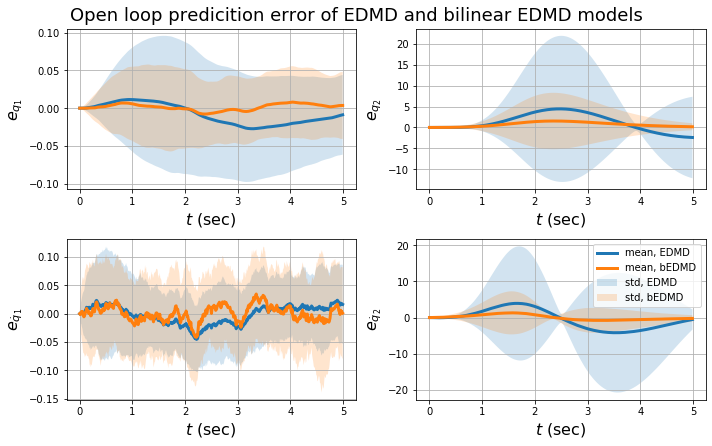

Lifting dimension EDMD:  35 Lifting dimension bEDMD:  45
MSE EDMD:  53.731686195393515 
MSE bilinear EDMD:  6.2480199733498285 
Improvement:  88.37181481588144  percent


In [12]:
from matplotlib import pyplot as plt
from koopman_core.controllers.openloop_controller import OpenLoopController

n_traj_test = 25
xs_test, xs_edmd_test, xs_bedmd_test, us_test, ts_test = [], [], [], [], []
for ii in range(n_traj_test):
    x_0 = np.asarray([rn.uniform(-i,i)  for i in traj_bounds])
    xs_tmp, us_tmp = finite_dim_koop_sys.simulate(x_0, pert_lqr_controller, t_eval)
    ol_controller = OpenLoopController(sys_bedmd, us_tmp, t_eval[:-1])

    z_0_edmd = basis_edmd(np.atleast_2d(x_0)).squeeze()
    zs_edmd_tmp, _ = sys_edmd.simulate(z_0_edmd, ol_controller, t_eval[:-1])
    xs_edmd_tmp = np.dot(C_edmd, zs_edmd_tmp.T)

    z_0_bedmd = basis_bedmd(np.atleast_2d(x_0)).squeeze()
    zs_bedmd_tmp, _ = sys_bedmd.simulate(z_0_bedmd, ol_controller, t_eval[:-1])
    xs_bedmd_tmp = np.dot(C_bedmd, zs_bedmd_tmp.T)

    xs_test.append(xs_tmp.T)
    xs_edmd_test.append(xs_edmd_tmp)
    xs_bedmd_test.append(xs_bedmd_tmp)
    us_test.append(us_tmp)
    ts_test.append(t_eval)

xs_test, xs_edmd_test, xs_bedmd_test, us_test, ts_test = \
    np.array(xs_test), np.array(xs_edmd_test), np.array(xs_bedmd_test), np.array(us_test), np.array(ts_test)

error_edmd = xs_test[:,:,:-1] - xs_edmd_test
error_edmd_mean = np.mean(error_edmd, axis=0)
error_edmd_std = np.std(error_edmd, axis=0)
mse_edmd = np.mean(np.mean(np.mean(np.square(error_edmd))))

error_bedmd = xs_test[:,:,:-1] - xs_bedmd_test
error_bedmd_mean = np.mean(error_bedmd, axis=0)
error_bedmd_std = np.std(error_bedmd, axis=0)
mse_bedmd = np.mean(np.mean(np.mean(np.square(error_bedmd))))

fig, axs = plt.subplots(2, 2, figsize=(10, 6))
ylabels = ['$e_{q_1}$', '$e_{q_2}$', '$e_{\dot{q}_1}$', '$e_{\dot{q}_2}$']
fig.suptitle('Open loop predicition error of EDMD and bilinear EDMD models', y=1.025, fontsize=18)
for ax, err_edmd_mean, err_edmd_std, err_bedmd_mean, err_bedmd_std, ylabel in zip(axs.flatten(), error_edmd_mean, error_edmd_std, error_bedmd_mean, error_bedmd_std, ylabels):
    ax.plot(ts_test[0,:-1], err_edmd_mean, linewidth=3, label='mean, EDMD')
    ax.fill_between(ts_test[0,:-1], err_edmd_mean-err_edmd_std, err_edmd_mean+err_edmd_std, alpha=0.2, label='std, EDMD')
    ax.plot(ts_test[0,:-1], err_bedmd_mean, linewidth=3, label='mean, bEDMD')
    ax.fill_between(ts_test[0,:-1], err_bedmd_mean-err_bedmd_std, err_bedmd_mean+err_bedmd_std, alpha=0.2, label='std, bEDMD')
    ax.set_ylabel(ylabel, fontsize=16)
    ax.grid()
    ax.set_xlabel('$t$ (sec)', fontsize=16)

ax.legend()
plt.tight_layout()
plt.show()
print('Lifting dimension EDMD: ', n_lift_edmd, 'Lifting dimension bEDMD: ', n_lift_bedmd*(m+1))
print('MSE EDMD: ', mse_edmd, '\nMSE bilinear EDMD: ', mse_bedmd, '\nImprovement: ', (1-mse_bedmd/mse_edmd)*100, ' percent')